<a href="https://colab.research.google.com/github/AShipulin/Train-Scheduler-Simulator-SimPy/blob/main/TrainSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# График движения поездов

График движения поездов строится с использованием дискретно-событийного имитационного моделирования.

Для построения используется библиотека SimPy.
В библиотеке существую "общие ресурсы" (PriorityResource), что подходит для принципов построения.

SimPy. Discrete event simulation for Python
* https://simpy.readthedocs.io/en/latest/
* https://pypi.org/project/simpy/
* https://gitlab.com/team-simpy/simpy/

Since you can easily forget this, all resources events are context managers (see the Python docs for details).

Примеры моделей:
- https://github.com/sisl/event-driven-rllab/blob/932d6cc0911071443d1d43277ee011f4d832631e/FirestormProject/OldEnvs/traffic_light_env.py#L99

## Описание

Однопутный участок из станйий s1, ...,sN и трех перегонов p1, ..., pN оброудованых двухсторонней автоблокировкой.

Размерность участка задется в **sta_cnt**.

Станция отправления поезда моежт быть любой из **sta_cnt**.

При отправлении поездов в повутном направлении учитывается:
- Интервала попутного отправления поездов Iот (тип Х) - IOt
- Интервала попутного прибытия Iпр (тип IX) 3,3...4,3 - IPr

При отправлении поездов во встречном направлении учитывается:
- Интервала скрещения τс (тип III) 0,5 - ISc

Дополнительно учитывается:
- Приоритеты поездов (очередность)
- Двухсторонняя автоблокировка

Абстрактная схема участка
```
-> Чет.              Неч. <-

                 <- Поезд 2001

IOt11   IOt11    IOt12    IOt1N
IPr11   IPr11    IPr12    IPr1N
ISc11   ISc11    ISc12    ISc1N
s0       s1       s2       s3
    p00       p0.       p0N
|---------|---------|---------|
    p10       p1.       p1N
ISc00   ISc01    ISc0.    ISc0N
IPr00   IPr01    IPr0.    IPr0N
IOt00   IOt01    IOt0.    IOt0N


Поеезд 2002 ->
```

В будщем:

- Время хода между станциями
- Время на рзгон
- Время на замедление
- Полуавтоблокировка
- Двухпутный и многопутные учаскти
- Дифиренсацию интервла для разных категорий поездов
- Количесто путей на станции для четных / нечетных поездов
- Занятость путей станции

Справочно:

- Полуавтоблокирка - обспечивает нахождение *одного* поезда на пути перегона.
В попутном направлении поезда отправляются с интервалом попутного следования. Во встречном направлении поезда отправляются с итервалом скрещения поездов

- автоблокировка - обспечивает нахождение *нескольких* поездов на пути перегона в попутном направлении. Следование в обратном направлениие (по неправильному пути) осуществляется по правилам полуавтоблокирки

- двухсторонняя автоблокировка - обспечивает нахождение *нескольких* поездов на пути перегона в попутном направлении. Следование в обратном направлениие осущетсвляется по правилам автоблокировки.


## Установка simpy и необходимых библиотк

In [ ]:
!pip install -U simpy
import simpy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

## Отрисовываем график движения поездов

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Графики занятости ресурсов
def show_res_busy(ax, x_max, title, resType, df_log_queue):

    ax.set_title(title)
    ax.set_xlim([0, x_max])
    ax.grid(True)
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    df = df_log_queue[(df_log_queue.dir == 0) & (df_log_queue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']+.2, df['sta']+.2], c='b', lw=5, alpha=0.75)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='b', ax=ax)
    df = df_log_queue[(df_log_queue.dir == 1) & (df_log_queue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']-.2, df['sta']-.2], c='r', lw=5, alpha=0.75)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='r', ax=ax)

    #df_sta = df_log_queue.drop_duplicates(subset=['sta'])
    #for index, row in df_sta.iterrows(): ax.axhline(y=row['sta'])
    #ax.get_yaxis().set_ticks(df_sta['sta'])

# Отрисовываем график движения поездов
def show_gts(train_schedule, log_queue, fs_width = 10, fs_height = 8, res_text = ['Way', 'ISc', 'IOt', 'IPr']):

    # Что отображаем
    ratios = []
    for r in res_text : ratios += [1]

    # Добавляем колонки в resQueue
    df_log_queue = pd.DataFrame(log_queue, columns=["res", "time", "dir", "sta", "cnt", "len"])
    df_log_queue = df_log_queue[(df_log_queue.cnt == 1)]
    df_log_queue['c'] = np.where(df_log_queue['dir'] == 1, 'r', 'g')

    # Добавим имена колонок
    df_train_schedule = pd.DataFrame(train_schedule, columns=["train", "sta", "time"])
    x_max = df_train_schedule['time'].max()  # Максимальное время

    # Создайте фигуру, содержащую одну ось
    fig, ax = plt.subplots(nrows=1+len(res_text), ncols=1, figsize=(fs_width, fs_height), gridspec_kw={'height_ratios': [3]+ratios})
    fig.tight_layout(h_pad=2)

    # Оси времени
    time_max = df_train_schedule['time'].max()
    ax[0].set_xlim([0, x_max])
    for i in range(10, time_max, 10):
        if i % 30 > 0: ax[0].axvline(x=i, linewidth=1)
    for i in range(30, time_max, 30):
        if i % 60 > 0: ax[0].axvline(x=i, linestyle='--', linewidth=1)
    for i in range(0, time_max, 60):
        ax[0].axvline(x=i, linestyle='-', linewidth=2)

    # Оси станций
    df_sta = df_train_schedule.drop_duplicates(subset=['sta'])
    plt.yticks(df_sta['sta'])
    ax[0].get_yaxis().set_ticks(df_sta['sta'])
    for index, row in df_sta.iterrows(): ax[0].axhline(y=row['sta'])

    # Подписи
    # plt.xlabel('Время, x')
    # plt.ylabel('Станции, y')
    # plt.title("График движения поездов")
    ax[0].set_ylabel('Станции, y')
    ax[0].set_title("График движения поездов")

    # Отключаем линии
    for sp in ['top', 'bottom', 'right', 'left']:
        ax[0].spines[sp].set_visible(False)

    # Рисуем нитки поездов
    df_train = df_train_schedule.groupby(['train']).first()
    for train, row in df_train.iterrows():
        t = df_train_schedule[(df_train_schedule['train'] == train)]
        y = t['sta']
        x = t['time']
        ax[0].plot(x, y, label=train, color='black' if train > 999 else 'red')
        # ax[0].text(row['time'], row['sta'], train)
        if train % 2 == 1:
            ax[0].text(row['time'] - 1, row['sta'] + .2, train)  # , rotation=-75.)
        else:
            ax[0].text(row['time'] - 1, row['sta'] - .2, train)  # , rotation=75.)
        # ax[0].legend()

    # Окно
    df_win = df_log_queue[(df_log_queue.res == 'Win') & (df_log_queue.len > 0)]
    ax[0].plot([df_win['time']-.1, df_win['time']+.1], [df_win['sta']+.2, df_win['sta']+1-.2], c='y', lw=5, alpha=0.25)

    i = 0
    for row in res_text:
        i +=1
        # Занятость пути перегона RWay
        if row == 'Way' : show_res_busy(ax[i], x_max, 'Занятость пути перегона RWay', 'Way', df_log_queue)

        # Интервала скрещения τс (тип III) 0,5 - ISc
        if row == 'ISc' : show_res_busy(ax[i], x_max, 'Интервала скрещения τс (тип III) 0,5 - ISc', 'ISc', df_log_queue)

        # Интервала попутного отправления поездов Iот (тип Х) - IOt
        if row == 'IOt' : show_res_busy(ax[i], x_max, 'Интервала попутного отправления Iот (тип Х) (3,25...7,25)', 'IOt', df_log_queue)

        # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3
        if row == 'IPr' : show_res_busy(ax[i], x_max, 'Интервала попутного прибытия Iпр (тип IX) 3,3...4,3', 'IPr', df_log_queue)

    ax[i].set_xlabel('Время, x')

    plt.show()

try:
    show_gts(train_schedule, log_queue, fs_width = 5, fs_height = 9, res_text = ['Way', 'ISc', 'IOt', 'IPr'])
except Exception as err:
    print(type(err))
    print(err.args)
    print(err)

<class 'NameError'>
("name 'train_schedule' is not defined",)
name 'train_schedule' is not defined


In [ ]:
class MyPriorityResource(simpy.PriorityResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

class MyPreemptiveResource(simpy.PreemptiveResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

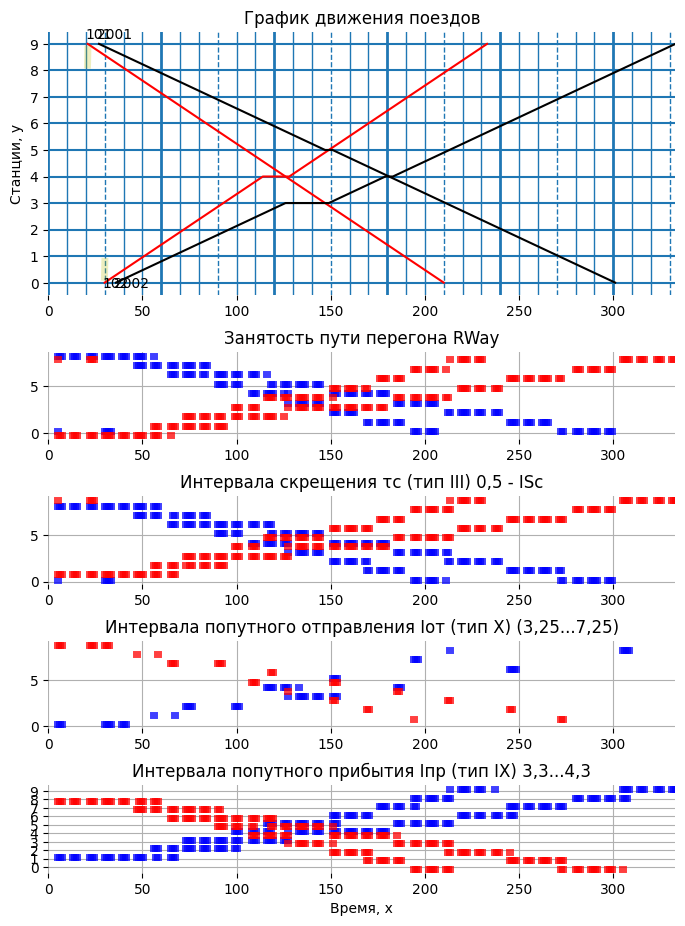

In [ ]:
class TrainSchedule:

    # Инициализация
    def __init__(self, env, sta_cnt = 4, until=1440, t_i_ot = 6, t_i_pr = 5, t_i_sc = 2):
        self.env = env
        self.sta_cnt = sta_cnt
        self.train_schedule = []
        self.log_queue = []
        self.log_data = [] # Таблица графика движения (человекочитаемая)
        self.until = until # Предельная задержка
        self.res_win_s = self.res_add(MyPreemptiveResource, i=1, n = sta_cnt - 1)
        self.res_way_s = self.res_add(MyPreemptiveResource, i=2, n = sta_cnt - 1)
        self.res_trn_s = self.res_add(MyPreemptiveResource, i=2, n = sta_cnt - 1)
        self.res_i_ot_s = self.res_add(MyPreemptiveResource, i=2, n = sta_cnt)
        self.res_i_pr_s = self.res_add(MyPreemptiveResource, i=2, n = sta_cnt)
        self.res_i_sc_s = self.res_add(MyPreemptiveResource, i=2, n = sta_cnt)
        self.t_i_ot = t_i_ot # Интервала попутного отправления Iот (тип Х) (3,25...7,25) - 8
        self.t_i_pr = t_i_pr # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3 - 5
        self.t_i_sc = t_i_sc # Интервала скрещения τс (тип III) 0,5 - 1
        self.run_proc()

    # Запускаем вспомогательные процессы
    def run_proc(self):

        # Лог занятия ресурсов
        self.env.process(self.queue_logger())

    # Генерация ресурсов
    def res_add(self, res, i, n):
        t = ()
        for d in range(i):
            l = []
            for r in range(n):
                l.append(res(self.env, capacity=1))
            t = t + (l,)
        return t

    # Сбор логов по ресурсу
    def queue_logger(self, t_step=1):
        res_list = [['Win', self.res_win_s],
                    ['Way', self.res_way_s],
                    ['Put', self.res_trn_s],
                    ['ISc', self.res_i_sc_s],
                    ['IOt', self.res_i_ot_s],
                    ['IPr', self.res_i_pr_s]]
        while True:
            # Каждый так добавляем
            for r, ress in enumerate(res_list):
                for i_dir, dir in enumerate(ress[1]):
                    for i_res, res in enumerate(dir):
                        item = (
                            ress[0],        # Ресурс (имя)
                            self.env.now,        # Текущее время
                            i_dir,          # Индекс направления
                            i_res,          # Индекс ресурса
                            res.count,      # Емкость очереди
                            len(res.queue)  # Дина очереди
                        )
                        self.log_queue.append(item)
            yield self.env.timeout(t_step)

    # Получение параметро движения
    def get_param(self, sta, mov, dir):

        #mov += random.randint(0, 5)
        sta = sta          # Станция отправления
        t_beg = 1          # Время на разгон
        t_mov = mov        # Время на движение
        t_end = 3          # Время на замедление

        if dir == 1:
            way = sta - 1      # Путь перегона
            sta_next = sta - 1 # Следующая станция
            way_next = way - 1 # Следующий путь перегона
            v = 0              # Встречное направление
            p = 1              # Попутное направление
        else:
            way = sta
            sta_next = sta + 1
            way_next = sta + 1
            v = 1
            p = 0

        res_win_s = self.res_win_s[0][way]  # Пусть перегона с окном
        res_way_v = self.res_way_s[v][way]  # Встречное направление
        res_way_p = self.res_way_s[p][way]  # Попутное направление
        res_trn_s = self.res_trn_s[p][way]


        # Интервал попутного отправления
        res_i_ot_p = self.res_i_ot_s[p][sta]  # Проверяем и занимаем

        # Интервал скрещения занимаем
        res_i_sc_next_v = self.res_i_sc_s[v][sta_next]  # Занимаем на следующей станции для встречных поездов
        res_i_sc_p = self.res_i_sc_s[p][sta]  # Проверяем

        # Интервал попутного прибытия
        res_i_pr_next_p = self.res_i_pr_s[p][sta_next]  # Занимаем на следующей станции для попутных поездов

        return (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
                res_win_s, res_trn_s, res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p)

    # Операция движения
    def driving(self, train, wait, prio, sta, mov, dir):

        (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
         res_win_s, res_trn_s, res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p) = self.get_param(sta, mov, dir)

        if t_mov < self.t_i_ot: raise ValueError(
            "Ограничение версии. Время хода меньше интервал попутного отправления")

        itrain = str(train).zfill(4) + f" ({sta}-{sta_next})"
        until = self.until
        while until  > 0:

            with res_i_ot_p.request(priority=prio) as req_i_ot_p:

                # Начало движения
                with (res_i_sc_p.request(priority=prio) as req_i_sc_p,          # Интервал скрещения, проверяем
                    res_way_p.request(priority=prio) as req_way_p,              # Попутное направления, проверяем
                    res_way_v.request(priority=prio) as req_way_v,              # Встречное направления, занимаем
                    res_i_sc_next_v.request(priority=prio) as req_i_sc_next_v,  # Интервал скрещения для встречных поездов, занимаем
                    res_win_s.request(priority=prio) as req_win_s,              # Окно на пути, проверяем
                    res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p   # Интервал попутного прибытия, проверяем и занимаем
                      ):
                    try:

                        # Ожидание отправления
                        put = self.env.now
                        #print('Поезд № %s Ожидание отправления (req_i_ot_p, req_i_sc_p, req_win_s) в %s с prio=%s' % (itrain, self.env.now, prio))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, 'Ожидание отправления', None, None, None, None])

                        # Интервал попутного отправления, ждем
                        # Интервал скрещения, ждем
                        # Путь перегона, ждем
                        # Окно, ждем
                        yield req_i_ot_p & req_i_sc_p & req_way_p & req_win_s

                        # Интервал скрещения, освобождаем
                        res_i_sc_p.release(req_i_sc_p)

                        # Путь перегона, освобождаем
                        res_way_p.release(req_way_p)

                        # Окно, осовобождаем
                        res_win_s.release(req_win_s)

                        # Попытка отправления
                        #print('Поезд № %s Попытка отправления в %s' % (itrain, env.now))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка отправления", self.env.now, None, self.env.now - put, None])
                        t_delay_beg = self.env.now - put
                        beg = self.env.now

                        # Интервал попутного отправления, выполняем
                        yield self.env.timeout(self.t_i_ot)

                        # Интервал попутного отправления, освобождаем
                        res_i_ot_p.release(req_i_ot_p)

                        # Проезжаем
                        yield self.env.timeout(t_mov - self.t_i_ot)

                        # Путь перегона встречный, освобождаем
                        res_way_v.release(req_way_v)

                        # Ожидание прибытия
                        t_delay_end_put = self.env.now
                        #print('Поезд № %s Ожидание прибытия (req_i_pr_next_p, req_win_s, req_way_p) в %s с priority=%s' % (itrain, env.now, prio))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Ожидание прибытия", beg, None, t_delay_beg, None])

                        # Интервал попутного прибытия, ждем
                        # Путь перегона попутный, ждем
                        # Окно, освобождаем-ждем-освобождаем
                        yield req_i_pr_next_p &  req_win_s & req_way_p

                        res_win_s.release(req_win_s)
                        #print('Поезд № %s Попытка прибытия в %s' % (itrain, env.now))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка прибытия", beg, self.env.now, t_delay_beg, self.env.now - t_delay_end_put])
                        t_delay_end = self.env.now - t_delay_end_put
                        until = 0

                        # Регистрируем события
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Прибытие", beg, self.env.now, t_delay_beg, t_delay_end])
                        self.train_schedule.append([train, sta, beg])
                        self.train_schedule.append([train, sta_next, self.env.now])

                        # Ставим в очередь cледующую операцию
                        if (sta_next < self.sta_cnt-1 and dir == 0) or (sta_next > 0 and dir == 1):
                            self.env.process(self.driving(train, wait=0, prio=prio, sta=sta_next, mov=mov, dir=dir))

                        # Завершаем интервалы:
                        # Интервал скрещения
                        # Интервал попутного прибытия
                        with (res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p):

                            # Интервал скрещения следующий встречный, выполняем
                            yield self.env.timeout(self.t_i_sc)

                            # Интервал скрещения следующий встречный, освобождаем
                            res_i_sc_next_v.release(req_i_sc_next_v)

                            # Интервал попутного прибытия, выполняем
                            yield self.env.timeout(self.t_i_pr - self.t_i_sc)

                    except simpy.Interrupt as interrupt:
                        by = interrupt.cause.by
                        usage = self.env.now - interrupt.cause.usage_since
                        until -= usage
                        #print(f'{itrain} Вытеснение операции {by} at {self.env.now} after {usage}')
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Вытеснение", None, None, None, None])

    # Поезд
    def train(self, train, wait, prio=None, sta = None, mov = None):
        dir = train%2
        if mov == None: mov = round(30.*.7) if train < 1000 else 30
        if sta == None: sta = self.sta_cnt if dir == 1 else 0
        if prio == None: prio = 100 if train < 1000 or 6000 < train and train < 8000 else 1000
        yield self.env.timeout(wait) # Время отправления поезда
        for s in range(self.sta_cnt-1, 0, -1) if dir == 1 else range(self.sta_cnt-1):
            if s >= sta and dir == 0 or s <= sta and dir == 1:
                op1 = self.env.process(self.driving(train, wait=0, prio=prio, sta=s, mov=mov, dir=dir))
                break

    # Окно
    def window(self, way, wait, dur):
        if way > self.sta_cnt-1: raise ValueError(
            'Не верно указан путь перегона для "Окна"')
        yield self.env.timeout(wait)
        res = self.res_win_s[0][way]
        res0 = self.res_way_s[0][way]
        res1 = self.res_way_s[1][way]
        print(self.env.now, 1)
        with (res.request(priority=-1) as req,
            res0.request(priority=-1) as req0,
            res1.request(priority=-1) as req1):
            yield self.env.timeout(dur)

# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until = 580
ts = TrainSchedule(env = env, sta_cnt = 10, until=until)


#env.process(ts.train(train=1001, wait=0))
#env.process(ts.train(train=1002, wait=5))
#
env.process(ts.train(train=101, wait=21))
env.process(ts.train(train=102, wait=30))
env.process(ts.train(train=2002, wait=5))
env.process(ts.train(train=2001, wait=5))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 7, 9)
#pd.DataFrame(log_data, columns=["train", "sta", "sta_n", "prio", "put", "oper","beg", "end", "d_beg", "d_end"])
#pd.DataFrame(ts.res_way_s[0][0].data, columns=["put", "oper", "proc", "cnt", "que"])
#ts.log_queue
#pd.DataFrame(train_schedule, columns=["train", "sta", "time"])
#pd.DataFrame(log_queue, columns=["res", "time", "dir", "sta", "cnt", "len"])

## Интервала скрещения τс (тип III) 0,5

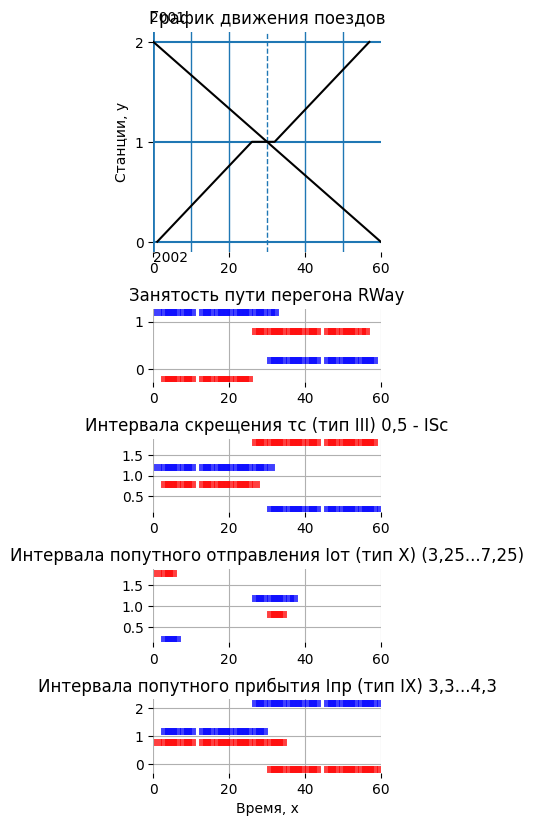

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=580
ts = TrainSchedule(env = env, sta_cnt = 3, until=until)

# Интервал скрещения
#t2001 = env.process(ts.train1(train=2001, wait=5, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))
#или
t2001 = env.process(ts.train(train=2001, wait=0))
t2002 = env.process(ts.train(train=2002, wait=1, mov=25))

# Не работает если отправить в одно время
#t2001 = env.process(ts.train1(train=2001, wait=0, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## Интервала попутного отправления Iот (тип Х) (3,25...7,25)

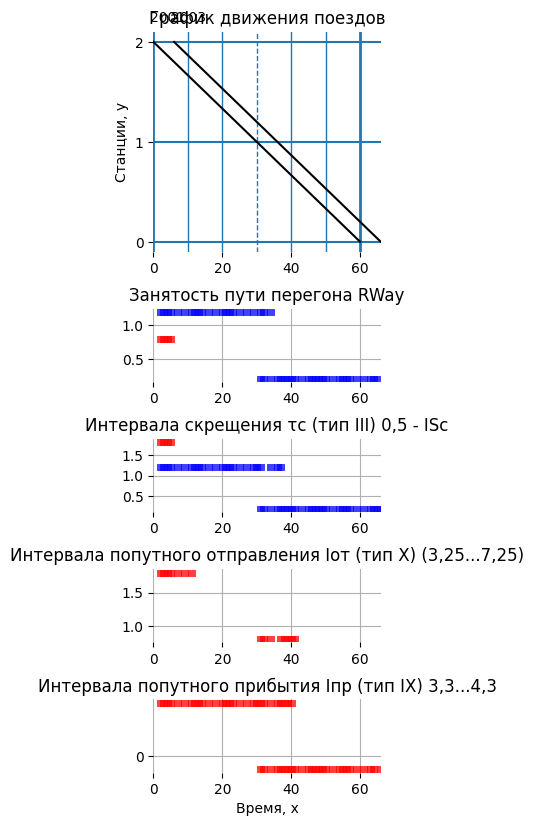

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=360
ts = TrainSchedule(env = env, sta_cnt = 3, until = until)

# Интервал попутного отправления
t2001 = env.process(ts.train(train=2001, wait=0, prio=2001))
t2003 = env.process(ts.train(train=2003, wait=1, prio=2003))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3

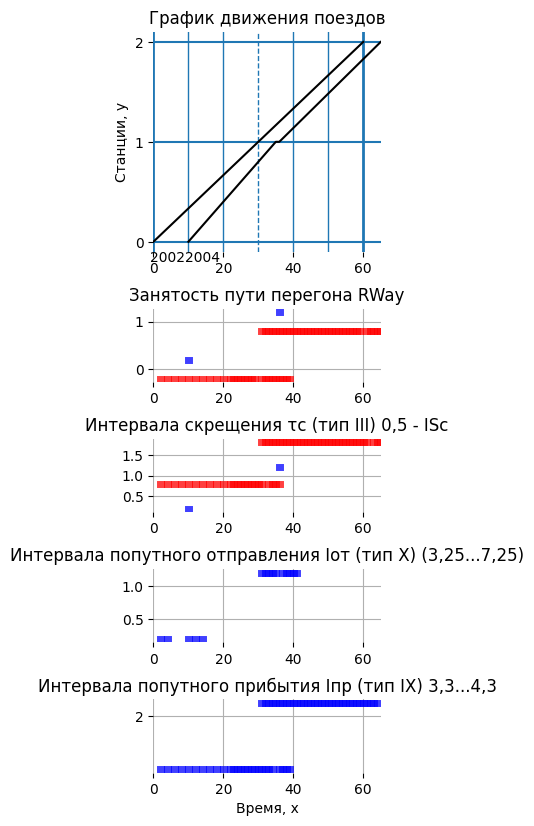

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=360
ts = TrainSchedule(env = env, sta_cnt = 3, until=until)

# Интервал попутного прибытия
t2002 = env.process(ts.train(train=2002, wait=0, mov=30))
t2004 = env.process(ts.train(train=2004, wait=10, mov=15))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)
#q = pd.DataFrame(ts.log_data, columns=["train", "sta", "sta_n", "prio", "put", "oper","beg", "end", "d_beg", "d_end"])
#q

## Обгоны

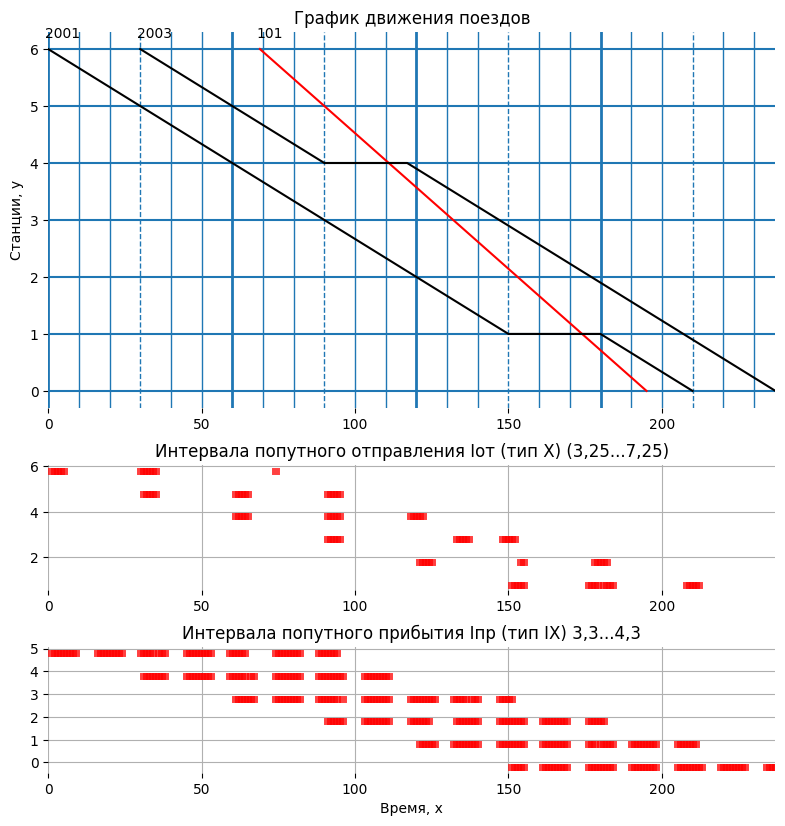

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 7)

# Приоритеты поездов
# Не можем обогнать поезд. 102 должен обогнать 2004
env.process(ts.train(train=2001, wait=0))
env.process(ts.train(train=2003, wait=30))
env.process(ts.train(train=101, wait=69))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, fs_width = 8, fs_height = 8, res_text = ['IOt', 'IPr'])
#ts.log_queue
#pd.DataFrame(log_data, columns=["train", "sta", "sta_n", "put", "beg", "end", "d_beg", "d_end"])

## Много поездов

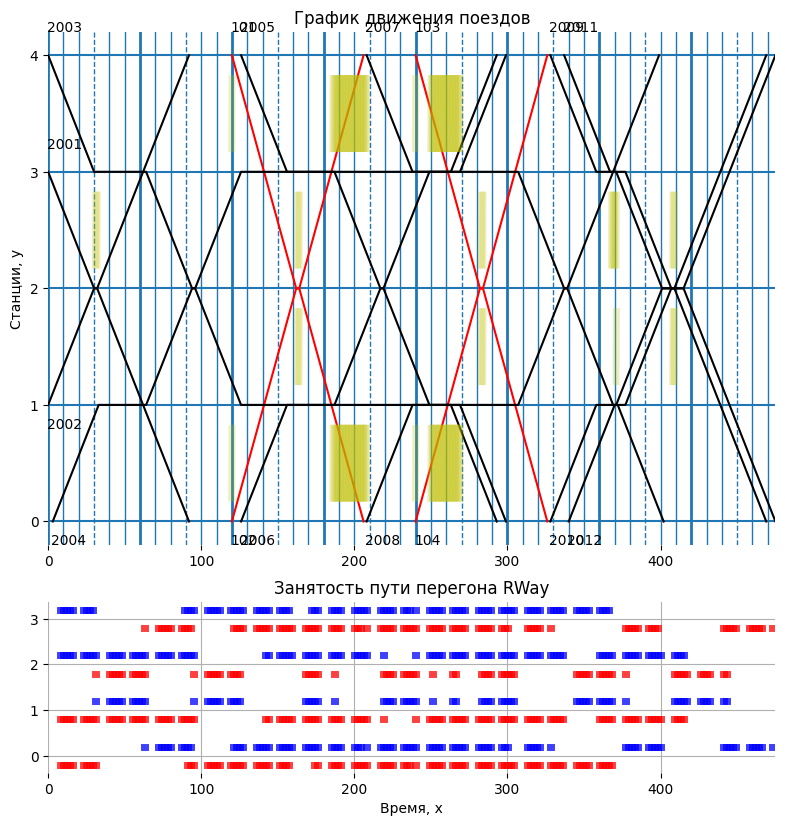

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=560
ts = TrainSchedule(env = env, sta_cnt = 5, until=until)

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(60,90)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=120))
env.process(ts.train(train=103, wait=240))
env.process(ts.train(train=102, wait=120))
env.process(ts.train(train=104, wait=240))

# Выполняем расчет
env.run(until=560)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 8, 8, res_text = ['Way'])

## Много поездов и окно

240 1


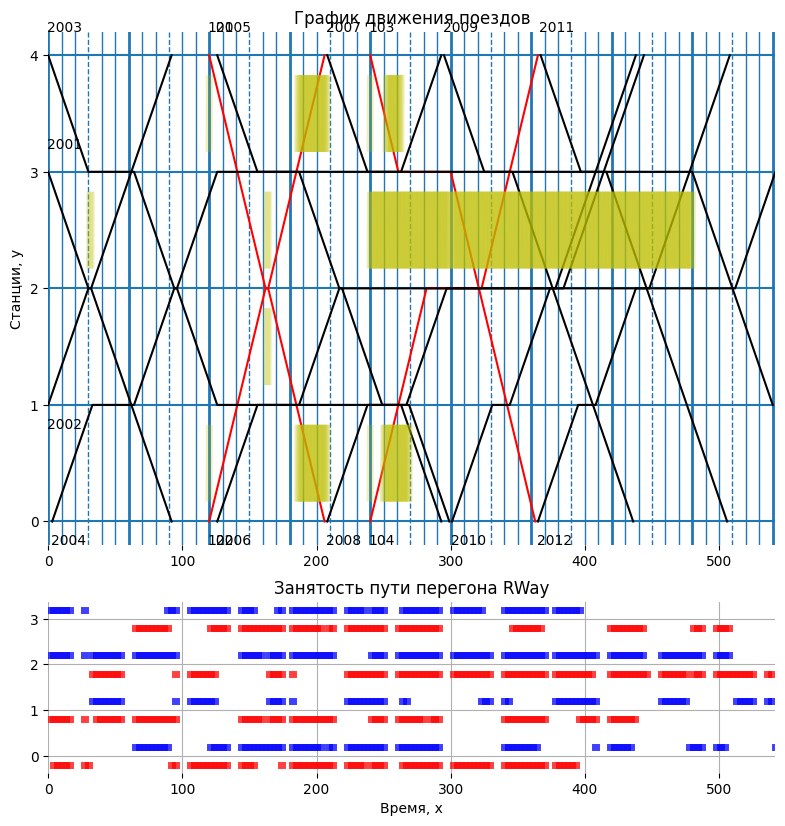

In [ ]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until=560
ts = TrainSchedule(env = env, sta_cnt = 5, until=until)

# окно
env.process(ts.window(way=2, wait=240, dur=60))

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(60,90)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=120))
env.process(ts.train(train=103, wait=240))
env.process(ts.train(train=102, wait=120))
env.process(ts.train(train=104, wait=240))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 8, 8, res_text = ['Way'])